# CoMM on text-image MM-IMDb 

This notebook will show how to use CoMM on the multimodal [MM-IMDb dataset](https://arxiv.org/abs/1702.01992). It contains 25959 movies along with their plot, poster and genres. The task consists in retrieving the movie genres from its plot (text) and poster (image). It is a **multi-class multi-label** classification task.

To run this notebook, first install and load the required packages:

In [ ]:
%pip install torch
%pip install omegaconf
%pip install hydra-core
%pip install pytorch-lightning
%pip install scikit-learn
%pip install torchvision
%pip install tensorboard
%pip install pandas
%pip install einops
%pip install sentence-transformers
%pip install salesforce-lavis

In [ ]:
import sys
import os
sys.path.append("../")
import numpy as np
import torch
from evaluation.linear_probe import evaluate_linear_probe
from dataset.mmimdb import MMIMDBDataModule
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pl_modules.comm import CoMM
from models.mmfusion import MMFusion
from models.vit import VisionTransformer
from models.transformer import LanguageEncoder
import textwrap
from models.blip2 import Blip2VisionTransformer, Blip2LanguageTransformer


/home/bdufumier/miniconda3/envs/blip/lib/python3.8/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/bdufumier/miniconda3/envs/blip/lib/python3.8/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/bdufumier/miniconda3/envs/blip/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/bdufumier/miniconda3/envs/blip/lib/python3.8/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from t

In [3]:
torch.manual_seed(42) # for reproducibility
np.random.seed(42)
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoid HF's warning 

## Download and visualize the data

Data need to be downloaded and extracted first (this may take a while, ~1h for 8GB):

In [ ]:
!wget https://archive.org/download/mmimdb/mmimdb.tar.gz
!tar -xvzf mmimdb.tar.gz
!rm mmimdb.tar.gz
!mv mmimdb /path/to/your/data # Replace with the path in 'dataset/catalog.json'

In [4]:
data_module = MMIMDBDataModule("CoMM", batch_size=64, num_workers=16)
downstream_task = MMIMDBDataModule("Sup", batch_size=64, num_workers=16)

Plot a few posters from the dataset with their plot:

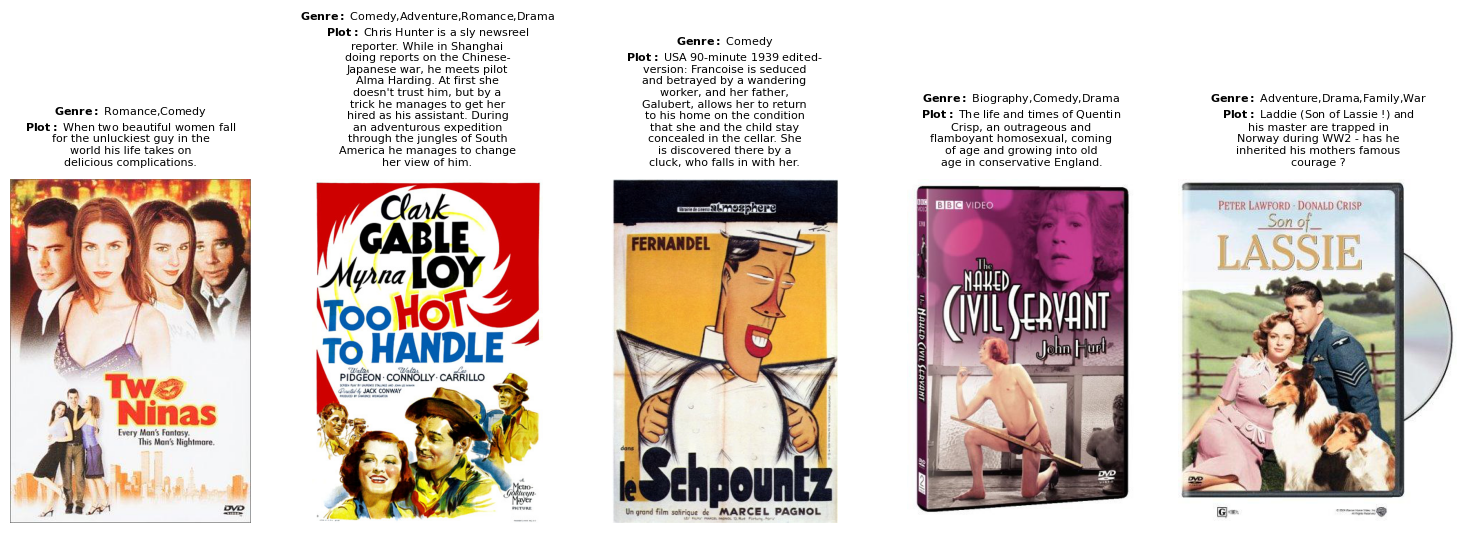

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
for i in range(5):
    image, caption, genre = downstream_task.val_dataset.get_raw_item(i)
    axes[i].imshow(image)
    axes[i].axis("off")
    wrapped_caption = "\n".join(textwrap.wrap(caption, width=30))
    wrapped_genres = textwrap.fill(",".join(genre), width=30) 
    # Set text below image
    text_str = (
            r"$\bf{Genre:}$ " + wrapped_genres + "\n" +
            r"$\bf{Plot:}$ " + wrapped_caption
    )
    axes[i].set_title(text_str, fontsize=8, loc="center", pad=10)
plt.tight_layout()
plt.show()

## Fit CoMM to MM-IMDb and score the model

In [ ]:
def multiclass_multilabel_scoring(model, data_module):
    Z_train, y_train = model.extract_features(data_module.train_dataloader())
    Z_val, y_val = model.extract_features(data_module.val_dataloader())
    Z_test, y_test = model.extract_features(data_module.test_dataloader())
    scores = evaluate_linear_probe(Z_train, y_train, Z_test, y_test, Z_val, y_val, multilabel=True)
    return scores["f1_mean"], scores["f1_weighted"]

### CoMM with CLIP backbone

In [7]:
comm = CoMM(
    encoder=MMFusion(
        encoders=[ # Handles vision and textual modalities
           VisionTransformer(
               model_name="vit_base_patch32_clip_224.openai",
               pretrained=True,
               output_value="token_embeddings",
               freeze=True),
            LanguageEncoder(
                model_name="clip-ViT-B-32-multilingual-v1",
                output_value="token_embeddings",
                normalize_embeddings=True,
                use_dataset_cache=False,
                mask_prob=0.15,
                freeze=True), 
        ], 
        input_adapters=[None, None], # No adapters needed
        embed_dim=768
    ),
    projection=CoMM._build_mlp(768, 512, 256),
    optim_kwargs=dict(lr=1e-4, weight_decay=1e-2),
    loss_kwargs=dict(temperature=0.1)
)

In [8]:
trainer = Trainer(inference_mode=False, max_epochs=70)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(comm, datamodule=data_module)

In [ ]:
macro_f1, weighted_f1 = multiclass_multilabel_scoring(comm.to("cuda:1"), downstream_task)

In [11]:
print(f"CoMM score on MM-IMDb: macro-f1={100*macro_f1:.2f}%, weight-f1={100*weighted_f1:.2f}%")

CoMM score on MM-IMDb: macro-f1=53.85%, weight-f1=61.44%


### CoMM with BLIP2 backbone

In [12]:
comm = CoMM(
    encoder=MMFusion(
        encoders=[ # Handles vision and textual modalities
            Blip2VisionTransformer(
               output_value="token_embeddings"
            ),
            Blip2LanguageTransformer(
                output_value="token_embeddings",
                mask_prob=0.15
            ), 
        ], 
        input_adapters=[None, None], # No adapters needed
        embed_dim=768
    ),
    projection=CoMM._build_mlp(768, 512, 256),
    optim_kwargs=dict(lr=1e-4, weight_decay=1e-2),
    loss_kwargs=dict(temperature=0.1)
)

In [15]:
trainer = Trainer(inference_mode=False, max_epochs=70)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(comm, datamodule=data_module)

In [ ]:
macro_f1, weighted_f1 = multiclass_multilabel_scoring(comm, downstream_task)

In [ ]:
print(f"CoMM score on MM-IMDb: macro-f1={100*macro_f1:.2f}%, weight-f1={100*weighted_f1:.2f}%")